In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.max_columns', 200)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
df = pd.read_csv('app_train_3.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16790 entries, 0 to 16789
Columns: 138 entries, TARGET to STATUS
dtypes: float64(59), int64(47), object(32)
memory usage: 17.7+ MB
None


,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_x,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV_x,NAME_CONTRACT_TYPE_y,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,WEEKDAY_APPR_PROCESS_START_y,HOUR_APPR_PROCESS_START_y,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS_x,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,SK_ID_PREV_y,MONTHS_BALANCE_x,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS_y,SK_DPD_x,SK_DPD_DEF_x,SK_ID_PREV_x.1,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_PREV_y.1,MONTHS_BALANCE_y,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD_y,SK_DPD_DEF_y,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,MONTHS_BALANCE,STATUS
0,0,Cash loans,F,N,Y,2,"198,000.00","641,173.50","23,157.00","553,500.00",Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.02,-17199,-768,-63.00,-735,1,1,1,1,1,0,Private service staff,4.00,2,2,THURSDAY,13,0,0,0,0,0,0,0.00,0.00,0.00,0.00,"-2,411.00",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,1.00,1.00,1737706,Consumer loans,"62,464.50","1,575,000.00","1,575,000.00","1,575,000.00",MONDAY,13,Y,1,XAP,Refused,-31,XNA,HC,XNA,Furniture,POS,XNA,Stone,100,XNA,36.00,low_normal,POS industry with interest,1185699,-71,8.00,0.00,Completed,0.00,0.00,"1,557,583.00",0.00,17.00,-705.00,-706.00,"20,989.67","20,989.67","1,557,583.00",-17.00,"333,135.14","427,500.00",0.00,"17,702.15","1,634.36","327,762.49","333,135.14","333,135.14",0.00,15.00,Active,0.00,0.00,Closed,currency 1,"-2,639.00",0.00,"-2,453.00","-2,516.00",0.00,"27,720.00",0.00,0.00,0.00,Consumer credit,"-2,513.00",-86.00,X
1,0,Cash loans,F,N,Y,0,"202,500.00","604,152.00","29,196.00","540,000.00",Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.01,-16971,-475,"-3,148.00",-513,1,1,0,1,1,0,Laborers,2.00,2,2,MONDAY,12,0,1,1,0,1,1,4.00,0.00,4.00,0.00,-458.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,5.00,1060558,Revolving loans,"11,250.00","225,000.00","225,000.00","225,000.00",THURSDAY,10,Y,1,XAP,Approved,-949,XNA,XAP,New,XNA,Cards,walk-in,Credit and cash offices,-1,XNA,0.00,XNA,C

## Exploratory Data Analysis (EDA)

### Banyak customer yang apply untuk pinjaman

In [3]:
noc = df.groupby('TARGET')['CODE_GENDER'].count().reset_index()
noc.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

noc['%'] = round(noc.Customers / noc.Customers.sum(), 2)
noc

,TARGET,Customers,%
0,0,15356,0.91
1,1,1434,0.09


Dari data di atas, diketahui bahwa 92% tidak memiliki kesulitan membayar pinjaman dalam waktu tertentu dan 8% memiliki permasalahan membayar pinjaman.

### Kemampuan membayar pinjaman berdasarkan status keluarga

In [4]:
df.NAME_FAMILY_STATUS.value_counts()

Married                 11560
Single / not married     1997
Civil marriage           1520
Separated                1050
Widow                     663
Name: NAME_FAMILY_STATUS, dtype: int64

In [5]:
Marital_status = []
married = ['Married', 'Civil marriage']

for i in df.NAME_FAMILY_STATUS:
    if i in married:
        Marital_status.append('Married')
    else:
        Marital_status.append('Unmarried')

df['Marital_status'] = Marital_status
df.drop(columns= 'NAME_FAMILY_STATUS', inplace=True)

In [6]:
ms= df[df['Marital_status'] == 'Unmarried'].groupby(['TARGET', 'Marital_status'])['CODE_GENDER'].count().reset_index()
ms.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

ms['%'] = round(ms.Customers / ms.Customers.sum(), 2)
ms

,TARGET,Marital_status,Customers,%
0,0,Unmarried,3403,0.92
1,1,Unmarried,307,0.08


In [7]:
ms1= df[df['Marital_status'] == 'Married'].groupby(['TARGET', 'Marital_status'])['CODE_GENDER'].count().reset_index()
ms1.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

ms1['%'] = round(ms1.Customers / ms1.Customers.sum(), 2)
ms1

,TARGET,Marital_status,Customers,%
0,0,Married,11953,0.91
1,1,Married,1127,0.09


Berdasarkan status keluarga, tidak ada perbedaan yang signifikan antara orang yang sudah menikah dan belum pada kesulitan membayar pinjaman.

### Occupation Type




In [8]:
ot = df.groupby(['TARGET', 'OCCUPATION_TYPE'])['CODE_GENDER'].count().reset_index().sort_values(by=['OCCUPATION_TYPE', 'TARGET'])
ot.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

name_of_ot = list(ot['OCCUPATION_TYPE'].unique())
percentage = []

for i in name_of_ot:
    data = ot[ot['OCCUPATION_TYPE'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

ot['%'] = percentage
ot

,TARGET,OCCUPATION_TYPE,Customers,%
0,0,Accountants,550,0.95
18,1,Accountants,28,0.05
1,0,Cleaning staff,232,0.89
19,1,Cleaning staff,30,0.11
2,0,Cooking staff,322,0.91
20,1,Cooking staff,32,0.09
3,0,Core staff,1315,0.93
21,1,Core staff,105,0.07
4,0,Drivers,959,0.88
22,1,Drivers,134,0.12


Dari jenis pekerjaan, Laborers memiliki jumlah apply pinjaman terbanyak, disusul dengan Sales staff, Core staff, Managers, dan Drivers. Namun, Sales staff dan drivers memiliki 10-12% nasabah yang tidak dapat melunaskan pinjaman.

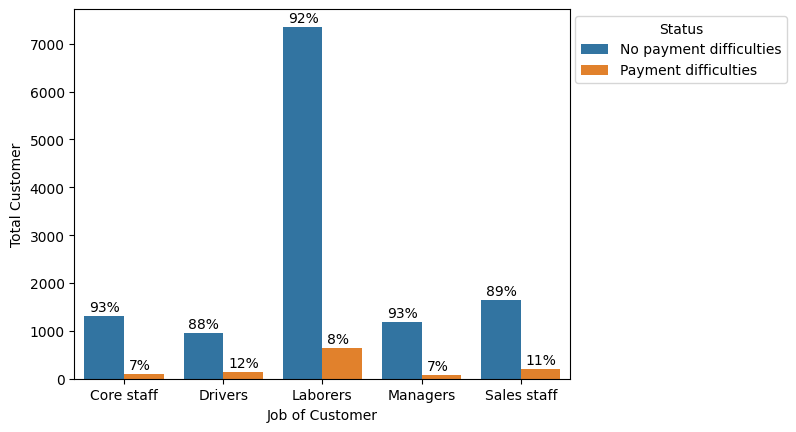

In [9]:
ot_2 = ot[ot['OCCUPATION_TYPE'].isin(['Laborers', 'Core staff', 'Managers', 'Sales staff', 'Drivers'])]
ot_2 = ot_2.reset_index()
ot_2.drop(columns = 'index', inplace=True)

mapping_target = {
    1 : 'Payment difficulties',
    0 : 'No payment difficulties'
}

ot_2['TARGET'] = ot_2['TARGET'].map(mapping_target)


ax = sns.barplot(x = 'OCCUPATION_TYPE', y= 'Customers', hue= 'TARGET', data = ot_2)
plt.xlabel('Job of Customer')
plt.ylabel('Total Customer')
plt.legend(title = 'Status', bbox_to_anchor = (1.45,1))

for i, v in enumerate(ot_2['Customers']):
    if i%2 == 0:
        plt.text(i / 2 - 0.35, v + 100, s=str(round(ot_2['%'][i] * 100)) + '%', color='black')
    else:
        plt.text(i / 2 - 0.45, v + 100, s=str(round(ot_2['%'][i] * 100)) + '%', color='black')

plt.show(ax)

### Umur Customer

In [10]:
df['Age'] = np.floor(df['DAYS_BIRTH'] / -365).astype(int)
df.drop(columns= 'DAYS_BIRTH', inplace=True)

In [11]:
age_cat = []
for i in df['Age']:
    if i < 36:
        age_cat.append('Young Adult')
    elif i < 51:
        age_cat.append('Adult')
    else:
        age_cat.append('Older')

df['Age_category'] = age_cat

In [12]:
g_age = df.groupby(['TARGET', 'Age_category'])['CODE_GENDER'].count().reset_index().sort_values('Age_category').reset_index()
g_age.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
g_age.drop(columns = 'index', inplace=True)

name_of_ot = list(g_age['Age_category'].unique())
percentage = []

for i in name_of_ot:
    data = g_age[g_age['Age_category'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

g_age['%'] = percentage

mapping_target = {
    1 : 'Payment difficulties',
    0 : 'No payment difficulties'
}

g_age['TARGET'] = g_age['TARGET'].map(mapping_target)
g_age

,TARGET,Age_category,Customers,%
0,No payment difficulties,Adult,6766,0.91
1,Payment difficulties,Adult,647,0.09
2,No payment difficulties,Older,4440,0.94
3,Payment difficulties,Older,287,0.06
4,No payment difficulties,Young Adult,4150,0.89
5,Payment difficulties,Young Adult,500,0.11


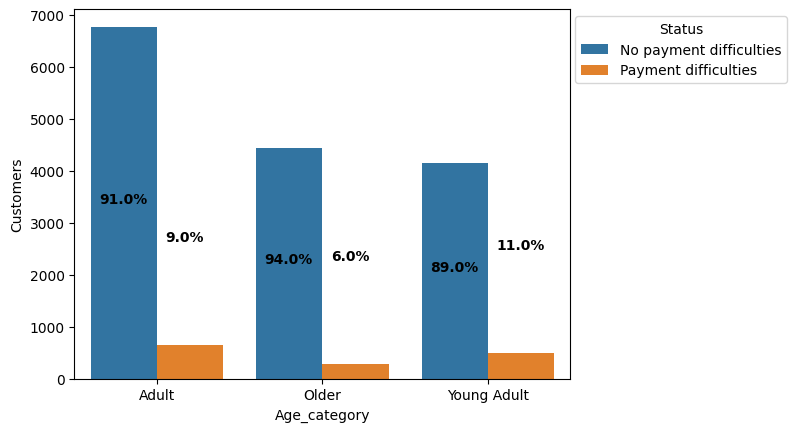

In [13]:
ax = sns.barplot(x = 'Age_category', y= 'Customers', hue= g_age.TARGET, data = g_age)
plt.legend(title = 'Status', bbox_to_anchor = (1.45,1))

for i, v in enumerate(g_age['Customers']):
    if i%2 == 0:
        plt.text(i/2 - 0.35, v/2, s= str(g_age['%'][i]* 100) + '%', color='black', fontweight='bold')
    else:
        plt.text(i/2 - 0.45, v + 2000, s= str(g_age['%'][i] * 100) + '%', color='black', fontweight='bold')

plt.show(ax)

Dari grafik di atas terlihat bahwa Adult/Dewasa (35-50 tahun) merupakan kategori usia yang memiliki pengajuan pinjaman terbesar yaitu sebesar 91%.

## Feature Engineering

In [14]:
x = df.drop(columns = 'TARGET')

### Numeric Data Type

In [15]:
num = x.select_dtypes(exclude='object')

In [16]:
num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV_x,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,HOUR_APPR_PROCESS_START_y,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,SK_ID_PREV_y,MONTHS_BALANCE_x,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD_x,SK_DPD_DEF_x,SK_ID_PREV_x.1,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_PREV_y.1,MONTHS_BALANCE_y,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD_y,SK_DPD_DEF_y,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,MONTHS_BALANCE,Age
0,2,"198,000.00","641,173.50","23,157.00","553,500.00",0.02,-768,-63.00,-735,1,1,1,1,1,0,4.00,2,2,13,0,0,0,0,0,0,0.00,0.00,0.00,0.00,"-2,411.00",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,1.00,1.00,1737706,"62,464.50","1,575,000.00","1,575,000.00","1,575,000.00",13,1,-31,100,36.00,1185699,-71,8.00,0.00,0.00,0.00,"1,557,583.00",0.00,17.00,-705.00,-706.00,"20,989.67","20,989.67","1,557,583.00",-17.00,"333,135.14","427,500.00",0.00,"17,702.15","1,634.36","327,762.49","333,135.14","333,135.14",0.00,15.00,0.00,0.00,"-2,639.00",0.00,"-2,453.00","-2,516.00",0.00,"27,720.00",0.00,0.00,0.00,"-2,513.00",-86.00,47
1,0,"202,500.00","604,152.00","29,196.00","540,000.00",0.01,-475,"-3,148.00",-513,1,1,0,1,1,0,2.00,2,2,12,0,1,1,0,1,1,4.00,0.00,4.00,0.00,-458.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,5.00,1060558,"11,250.00","225,000.00","225,000.00","225,000.00",10,1,-949,-1,0.00,1366912,-4,18.00,12.00,0.00,0.00,"1,366,912.00",1.00,1.00,-284.00,-291.00,"57,466.53","57,466.53","1,060,558.00",-23.00,"98,006.35","225,000.00",0.00,"6,557.44","18,000.00","95,148.76","99,112.99","99,112.99",0.00,7.00,0.00,0.00,-75.00,0.00,-66.00,-66.00,0.00,"22,905.00",0.00,0.00,0.00,-61.00,-2.00,46
2,0,"108,000.00","746,280.00","42,970.50","675,000.00",0.01,365243,"-5,745.00",-4576,1,0,0,1,0,0,1.00,2,2,9,0,0,0,0,0,0,0.00,0.00,0.00,0.00,-491.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,3.00,1794209,"9,000.00","180,000.00","180,000.00","180,000.00",9,1,-231,-1,0.00,2243464,-10,24.00,18.00,0.00,0.00,"2,243,464.00",1.00,15.00,-39.00,-49.00,"6,919.60","6,919.60","1,794,209.00",-3.00,0.00,"180,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-694.00,0.00,189.00,-145.00,0.00,"450,000.00",0.00,0.00,0.00,-135.00,-14.00,64
3,1,"540,000.00","675,000.00","34,596.00","675,000.00",0.03,-6977,"-3,904.00",-1937,1,1,0,1,1,0,3.00,2,2,10,0,0,0,0,0,0,2.00,0.00,2.00,0.00,"-1,285.00",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,1.00,0.00,0.00,3.00,1885254,"16,294.50","450,000.00","450,000.00","450,000.00"

In [17]:
# numeric data type yang mempunyai lebih dari 2 unique value
df_num = pd.DataFrame(num.nunique(), columns = ['Total_unique']).reset_index()
df_num = df_num.rename(columns = {'index' : 'Name_of_column'})

num_a = []
num_b = []
for i,y in enumerate(df_num.Name_of_column):
    if df_num['Total_unique'][i] > 2:
        num_a.append(y)
    else:
        num_b.append(y)

In [18]:
# # Data distribution
# plt.figure(figsize=(10,10))

# for i, column in enumerate (num[num_a].columns, 1):
#     plt.subplot(10,25,i)
#     sns.kdeplot(data=num[num_a], x=num[column])
#     plt.tight_layout()

In [19]:
# # Menormalisasikan distribusi data
# plt.figure(figsize=(20,12))

# for i, column in enumerate (num[num_a].columns, 1):
#     plt.subplot(7,10,i)
#     sns.boxplot(data=num[num_a], x=num[column])
#     plt.tight_layout()

In [20]:
# Handling Outlier

for j in num:
    Q1 = num[j].quantile(0.25)
    Q3 = num[j].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - (1.5 * IQR)
    upper = Q3 + (1.5 * IQR)
    filter_nonoutlier = (num[j] >= lower) & (num[j] <= upper)
    num = num[filter_nonoutlier]
num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV_x,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,HOUR_APPR_PROCESS_START_y,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,SK_ID_PREV_y,MONTHS_BALANCE_x,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD_x,SK_DPD_DEF_x,SK_ID_PREV_x.1,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_PREV_y.1,MONTHS_BALANCE_y,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD_y,SK_DPD_DEF_y,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,MONTHS_BALANCE,Age
290,1,"157,500.00","364,896.00","22,180.50","315,000.00",0.03,-849,"-4,130.00",-2793,1,1,0,1,0,0,3.00,2,2,11,0,0,0,0,0,0,0.00,0.00,0.00,0.00,-353.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,2.00,5.00,1768715,"9,000.00","180,000.00","180,000.00","180,000.00",8,1,-212,-1,0.00,2080714,-16,10.00,3.00,0.00,0.00,"1,381,165.00",1.00,1.00,"-2,276.00","-2,262.00","11,238.98",17.86,"2,331,701.00",-5.00,0.00,"180,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-352.00,0.00,-49.00,-49.00,0.00,"59,796.00",0.00,0.00,0.00,-37.00,-3.00,27
363,0,"135,000.00","855,000.00","27,580.50","855,000.00",0.03,-3740,"-3,711.00",-3512,1,1,0,1,0,0,1.00,2,2,10,0,0,0,0,0,0,1.00,0.00,1.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,2.00,2674340,"11,250.00",0.00,"225,000.00","112,320.00",11,1,-1475,-1,0.00,1848797,-23,10.00,3.00,0.00,0.00,"1,240,452.00",2.00,10.00,"-1,493.00","-1,494.00","14,114.75","14,114.75","2,674,340.00",-13.00,0.00,"45,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"-2,017.00",0.00,"-1,553.00","-1,553.00",0.00,"107,482.50",0.00,0.00,0.00,"-1,313.00",-5.00,54
365,0,"157,500.00","1,113,840.00","57,001.50","900,000.00",0.01,-3664,"-10,537.00",-2678,1,1,0,1,0,0,2.00,2,2,13,0,0,0,0,0,0,0.00,0.00,0.00,0.00,"-1,477.00",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,4.00,1522711,"2,250.00","45,000.00","45,000.00","45,000.00",16,1,-242,-1,0.00,1623325,-11,12.00,4.00,0.00,0.00,"1,772,575.00",1.00,8.00,-2.00,-5.00,"11,992.27","11,992.27","1,522,711.00",-7.00,0.00,"45,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"-2,656.00",0.00,"-1,558.00","-1,557.00",0.00,"72,018.00",0.00,0.00,0.00,"-1,556.00",-56.00,53
422,0,"157,500.00","787,131.00","42,066.00","679,500.00",0.02,-789,"-6,033.00",-3423,1,1,0,1,0,0,1.00,2,2,15,0,0,0,0,0,0,1.00,0.00,1.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,1188809,"8,354.52","83,961.00","44,473.50","83,961.00",16,1,-206,152,6.00,1180295,-82,12.00,11.00,0.00,0.00,"1,188,809.00",1.00,1.00

In [21]:
# Standarisasi fitur

from sklearn.preprocessing import StandardScaler

for k in num:
    num[k] = StandardScaler().fit_transform(num[k].values.reshape(len(num),1))

num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV_x,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,HOUR_APPR_PROCESS_START_y,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,SK_ID_PREV_y,MONTHS_BALANCE_x,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD_x,SK_DPD_DEF_x,SK_ID_PREV_x.1,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_PREV_y.1,MONTHS_BALANCE_y,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD_y,SK_DPD_DEF_y,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,MONTHS_BALANCE,Age
290,0.84,0.12,-0.38,-0.29,-0.40,0.83,0.80,0.18,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.95,0.00,0.00,-0.27,0.00,0.00,0.00,0.00,0.00,0.00,-0.60,0.00,-0.60,0.00,0.73,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.58,1.18,-0.39,-0.06,2.56,2.22,2.29,-1.41,0.00,0.68,-0.64,-1.69,0.29,0.52,-0.15,-0.61,0.00,0.00,-0.95,0.06,-1.04,-1.85,-1.80,0.26,-1.64,0.77,0.44,0.00,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.08,0.00,0.83,1.34,0.00,-0.45,0.00,0.00,0.00,1.14,1.13,-1.40
363,-0.70,-0.29,1.25,0.16,1.63,0.96,-1.11,0.32,-0.42,0.00,0.00,0.00,0.00,0.00,0.00,-1.43,0.00,0.00,-0.63,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.08,0.00,1.19,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.61,-0.57,1.29,0.44,-0.97,3.02,0.59,-0.47,0.00,-1.06,-0.64,-1.69,-0.17,0.25,-0.15,-0.61,0.00,0.00,-1.22,3.64,1.04,-0.84,-0.82,0.80,0.89,1.44,-1.04,0.00,-0.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.56,0.00,-1.51,-1.61,0.00,0.25,0.00,0.00,0.00,-1.53,0.99,1.56
365,-0.70,0.12,2.12,2.58,1.80,-0.71,-1.06,-1.92,0.12,0.00,0.00,0.00,0.00,0.00,0.00,-0.24,0.00,0.00,0.45,0.00,0.00,0.00,0.00,0.00,0.00,-0.60,0.00,-0.60,0.00,-0.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.61,0.60,-0.84,-1.55,-0.08,-0.18,-1.10,1.10,0.00,0.64,-0.64,-1.69,-0.62,0.72,0.21,-0.43,0.00,0.00,-0.19,0.06,0.58,1.07,1.08,0.40,0.51,-0.83,0.07,0.00,-0.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.57,0.00,-1.52,-1.62,0.00,-0.27,0.00,0.00,0.00,-2.04,-2.55,1.45
422,-0.70,0.12,1.03,1.35,0.97,0.77,0.84,-0.44,-0.36,0.00,0.00,0.00,0.00,0.00,0.00,-1.43,0.00,0.00,1.18,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.08,0.00,1.19,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.61,-1.73,-1.46,-0.20,0.68,-0.19,-0.12,1.10,0.00,0.69,1.96,-0.50,-1.50,-2.02,0.21,0.87,0.00,0.00,-1.32,0.06,-1.04,0.85,0.8

### Object Data Type

In [ ]:
# # Feature
# obj = x.select_dtypes(include='object')
# df_obj = pd.DataFrame(obj.nunique(), columns = ['Total_unique']).reset_index()
# df_obj = df_obj.rename(columns = {'index' : 'Name_of_column'})

# obj_1 = []
# obj_2 = []
# for i,y in enumerate(df_obj.Name_of_column):
#     if df_obj['Total_unique'][i] > 2:
#         obj_1.append(y)
#     else:
#         obj_2.append(y)
# obj

,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START_x,NAME_CONTRACT_TYPE_y,WEEKDAY_APPR_PROCESS_START_y,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS_x,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION,NAME_CONTRACT_STATUS_y,NAME_CONTRACT_STATUS,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE,STATUS,Marital_status,Age_category
0,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,House / apartment,Private service staff,THURSDAY,Consumer loans,MONDAY,Y,XAP,Refused,XNA,HC,XNA,Furniture,POS,XNA,Stone,XNA,low_normal,POS industry with interest,Completed,Active,Closed,currency 1,Consumer credit,X,Married,Adult
1,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Laborers,MONDAY,Revolving loans,THURSDAY,Y,XAP,Approved,XNA,XAP,New,XNA,Cards,walk-in,Credit and cash offices,XNA,XNA,Card Street,Active,Active,Closed,currency 1,Microloan,0,Married,Adult
2,Cash loans,F,N,Y,Unaccompanied,Pensioner,Higher education,House / apartment,Laborers,WEDNESDAY,Revolving loans,WEDNESDAY,Y,XAP,Approved,XNA,XAP,Repeater,XNA,Cards,x-sell,Credit and cash offices,XNA,XNA,Card X-Sell,Active,Active,Closed,currency 1,Consumer credit,X,Unmarried,Older
3,Cash loans,M,Y,Y,Unaccompanied,Commercial associate,Higher education,House / apartment,Managers,TUESDAY,Cash loans,FRIDAY,Y,XNA,Approved,Cash through the bank,XAP,Repeater,XNA,Cash,x-sell,Credit and cash offices,XNA,low_normal,Cash X-Sell: low,Active,Active,Closed,currency 1,Consumer credit,0,Married,Older
4,Cash loans,M,Y,Y,Unaccompanied,Working,Higher education,House / apartment,Managers,FRIDAY,Cash loans,WEDNESDAY,Y,Repairs,Approved,Cash through the bank,XAP,Repeater,XNA,Cash,walk-in,Credit and cash offices,XNA,middle,Cash Street: middle,Active,Active,Closed,currency 1,Car loan,X,Married,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28920,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,House / apartment,Sales staff,FRIDAY,Consumer loans,SATURDAY,Y,XAP,Approved,XNA,XAP,New,Consumer Electronics,POS,XNA,Regional / Local,Consumer electronics,middle,POS household with interest,Active,Active,Active,currency 1,Consumer credit,0,Married,Adult
28921,Cash loans,M,Y,Y,Unaccompanied,Commercial associate,Secondary / secondary special,House / apartment,Drivers,SATURDAY,Revolving loans,THURSDAY,Y,XAP,Approved,XNA,XAP,Repeater,XNA,Cards,walk-in,Stone,Construction,XNA,Card Street,Active,Active,Active,currency 1,Mortgage,C,Married,Young Adult
28922,Cash loans,M,Y,Y,Unaccompanied,Commercial associate,Secondary / secondary special,House / apartment,Laborers,MONDAY,Consumer loans,TUESDAY,Y,XAP,Approved,Cash through the bank,XAP,New,Audio/Video,POS,XNA,Country-wide,Consumer electronics,middle,POS household with interest,Active,Active,Active,currency 1,Credit card,0,Married,Older
28923,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,House / apartment,Laborers,FRIDAY,Cash loans,TUESDAY,Y,XNA,Canceled,XNA,XAP,Repeater,XNA,XNA,XNA,Contact center,XNA,XNA,Cash,Active,Active,Active,currency 1,Credit card,0,Married,Older


In [ ]:
# for cat in obj:
#     obj = pd.get_dummies(df, drop_first=True)

In [ ]:
# # label_encoder object knows how to understand word labels.
# label_encoder = preprocessing.LabelEncoder()

# # Encode labels in column 'species'.
# for cat in obj_2:
#     obj[cat]= label_encoder.fit_transform(obj[cat])

# obj

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV_x,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,HOUR_APPR_PROCESS_START_y,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,SK_ID_PREV_y,MONTHS_BALANCE_x,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD_x,SK_DPD_DEF_x,SK_ID_PREV_x.1,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_PREV_y.1,MONTHS_BALANCE_y,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD_y,SK_DPD_DEF_y,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_x_MONDAY,WEEKDAY_APPR_PROCESS_START_x_SATURDAY,WEEKDAY_APPR_PROCESS_START_x_SUNDAY,WEEKDAY_APPR_PROCESS_START_x_THURSDAY,WEEKDAY_APPR_PROCESS_START_x_TUESDAY,WEEKDAY_APPR_PROCESS_START_x_WEDNESDAY,NAME_CONTRACT_TYPE_y_Consumer loans,NAME_CONTRACT_TYPE_y_Revolving loans,NAME_CONTRACT_TYPE_y_XNA,WEEKDAY_APPR_PROCESS_START_y_MONDAY,WEEKDAY_APPR_PROCESS_START_y_SATURDAY,WEEKDAY_APPR_PROCESS_START_y_SUNDAY,WEEKDAY_APPR_PROCESS_START_y_THURSDAY,WEEKDAY_APPR_PROCESS_START_y_TUESDAY,WEEKDAY_APPR_PROCESS_START_y_WEDNESDAY,NAME_CASH_LOAN_PURPOSE_XAP,NAME_CASH_LOAN_PURPOSE_XNA,NAME_CONTRACT_STATUS_x_Canceled,NAME_CONTRACT_STATUS_x_Refused,NAME_CONTRACT_STATUS_x_Unused offer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_XAP,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_GOODS_CATEGORY_Auto Accessories,NAME_GOODS_CATEGORY_Clothing and Accessories,NAME_GOODS_CATEGORY_Computers,NAME_GOODS_CATEGORY_Construction Materials,NAME_GOODS_CATEGORY_Consumer Electronics,NAME_GOODS_CATEGORY_Furniture,NAME_GOODS_CATEGORY_Mobile,NAME_GOODS_CATEGORY_XNA,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_SELLER_INDUSTRY_Clothing,NAME_SELLER_INDUSTRY_Connectivity,NAME_SELLER_INDUSTRY_Construction,NAME_SELLER_INDUSTRY_Consumer electronics,NAME_SELLER_INDUSTRY_Furniture,NAME_SELLER_INDUSTRY_MLM partners,NAME_SELLER_INDUSTRY_XNA,NAME_YIELD_GROUP_high,N

### Object

In [22]:
obj = x.select_dtypes(include='object')
obj = pd.get_dummies(obj, drop_first=True)

In [23]:
df_train = pd.concat([num, obj], axis=1)

In [24]:
df = pd.concat([df_train, df['TARGET']],axis=1)

In [25]:
df.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV_x,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,HOUR_APPR_PROCESS_START_y,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,SK_ID_PREV_y,MONTHS_BALANCE_x,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD_x,SK_DPD_DEF_x,SK_ID_PREV_x.1,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_PREV_y.1,MONTHS_BALANCE_y,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD_y,SK_DPD_DEF_y,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_GOODS_CATEGORY_Audio/Video,NAME_GOODS_CATEGORY_Auto Accessories,NAME_GOODS_CATEGORY_Clothing and Accessories,NAME_GOODS_CATEGORY_Computers,NAME_GOODS_CATEGORY_Construction Materials,NAME_GOODS_CATEGORY_Consumer Electronics,NAME_GOODS_CATEGORY_Direct Sales,NAME_GOODS_CATEGORY_Education,NAME_GOODS_CATEGORY_Fitness,NAME_GOODS_CATEGORY_Furniture,NAME_GOODS_CATEGORY_Gardening,NAME_GOODS_CATEGORY_Homewares,NAME_GOODS_CATEGORY_Jewelry,NAME_GOODS_CATEGORY_Medical Supplies,NAME_GOODS_CATEGORY_Medicine,NAME_GOODS_CATEGORY_Mobile,NAME_GOODS_CATEGORY_Office Appliances,NAME_GOODS_CATEGORY_Other,NAME_GOODS_CATEGORY_Photo / Cinema Equipment,NAME_GOODS_CATEGORY_Sport and Leisure,NAME_GOODS_CATEGORY_Tourism,NAME_GOODS_CATEGORY_Vehicles,NAME_GOODS_CATEGORY_XNA,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_SELLER_INDUSTRY_Clothing,NAME_SELLER_INDUSTRY_Connectivity,NAME_SELLER_INDUSTRY_Construction,NAME_SELLER_INDUSTRY_Consumer electronics,NAME_SELLER_INDUSTRY_Furniture,NAME_SELLER_INDUSTRY_Industry,NAME_SELLER_INDUSTRY_Jewelry,NAME_SELLER_INDUSTRY_MLM partners,NAME_SELLER_INDUSTRY_Tourism,NAME_SELLER_INDUSTRY_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODU

## Data Pre-processing

In [26]:
# Mencari data duplikat
df.duplicated().sum()

39

In [27]:
df.drop_duplicates()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV_x,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,HOUR_APPR_PROCESS_START_y,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,SK_ID_PREV_y,MONTHS_BALANCE_x,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD_x,SK_DPD_DEF_x,SK_ID_PREV_x.1,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_PREV_y.1,MONTHS_BALANCE_y,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD_y,SK_DPD_DEF_y,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_GOODS_CATEGORY_Audio/Video,NAME_GOODS_CATEGORY_Auto Accessories,NAME_GOODS_CATEGORY_Clothing and Accessories,NAME_GOODS_CATEGORY_Computers,NAME_GOODS_CATEGORY_Construction Materials,NAME_GOODS_CATEGORY_Consumer Electronics,NAME_GOODS_CATEGORY_Direct Sales,NAME_GOODS_CATEGORY_Education,NAME_GOODS_CATEGORY_Fitness,NAME_GOODS_CATEGORY_Furniture,NAME_GOODS_CATEGORY_Gardening,NAME_GOODS_CATEGORY_Homewares,NAME_GOODS_CATEGORY_Jewelry,NAME_GOODS_CATEGORY_Medical Supplies,NAME_GOODS_CATEGORY_Medicine,NAME_GOODS_CATEGORY_Mobile,NAME_GOODS_CATEGORY_Office Appliances,NAME_GOODS_CATEGORY_Other,NAME_GOODS_CATEGORY_Photo / Cinema Equipment,NAME_GOODS_CATEGORY_Sport and Leisure,NAME_GOODS_CATEGORY_Tourism,NAME_GOODS_CATEGORY_Vehicles,NAME_GOODS_CATEGORY_XNA,NAME_PORTFOLIO_Cars,NAME_PORTFOLIO_Cash,NAME_PORTFOLIO_POS,NAME_PORTFOLIO_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_SELLER_INDUSTRY_Clothing,NAME_SELLER_INDUSTRY_Connectivity,NAME_SELLER_INDUSTRY_Construction,NAME_SELLER_INDUSTRY_Consumer electronics,NAME_SELLER_INDUSTRY_Furniture,NAME_SELLER_INDUSTRY_Industry,NAME_SELLER_INDUSTRY_Jewelry,NAME_SELLER_INDUSTRY_MLM partners,NAME_SELLER_INDUSTRY_Tourism,NAME_SELLER_INDUSTRY_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODU

In [28]:
df.isna().any().sum()

105

In [29]:
df.dropna(inplace=True)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128 entries, 290 to 16755
Columns: 298 entries, CNT_CHILDREN to TARGET
dtypes: float64(105), int64(1), uint8(192)
memory usage: 131.0 KB


### Pisahkan target dan features

In [30]:
x = df.drop(columns = 'TARGET')
y = df['TARGET']

### Over sampling

In [31]:
sm = SMOTE(random_state = 2)
x_over, y_over = sm.fit_resample(x, y.to_numpy().ravel())

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.3, random_state=42)

### Under sampling

In [35]:
rus = RandomUnderSampler(random_state=42)
x_under, y_under = rus.fit_resample(x, y.ravel())

In [36]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_under, y_under, test_size=0.3, random_state=42)

## Machine Learning Model

### Logistic Regression Model

#### Oversampling

In [37]:
def confusionmatrix(predictions, y_test):
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    return disp.plot()

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        38
           1       0.95      1.00      0.97        35

    accuracy                           0.97        73
   macro avg       0.97      0.97      0.97        73
weighted avg       0.97      0.97      0.97        73



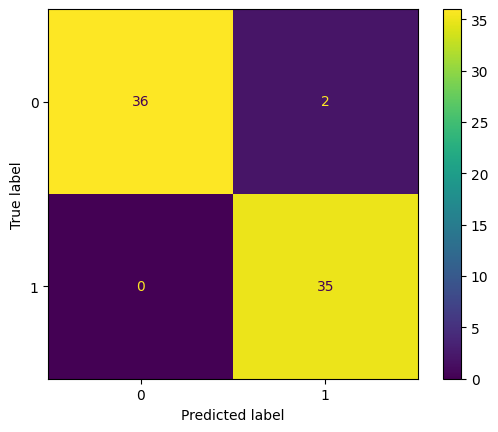

In [38]:
lr1 = LogisticRegression()
lr1.fit(x_train, y_train.ravel())
predictions = lr1.predict(x_test)

# print classification report
print(classification_report(y_test, predictions))
confusionmatrix(predictions, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        83
           1       1.00      1.00      1.00        86

    accuracy                           1.00       169
   macro avg       1.00      1.00      1.00       169
weighted avg       1.00      1.00      1.00       169



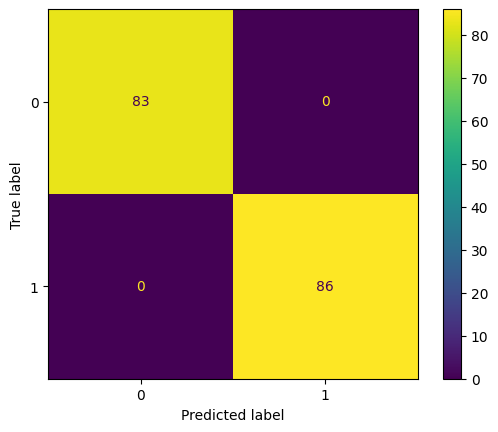

In [39]:
predictions = lr1.predict(x_train)

# print classification report
print(classification_report(y_train, predictions))
confusionmatrix(predictions, y_train)

#### Undersampling

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      0.33      0.33         3

    accuracy                           0.20         5
   macro avg       0.17      0.17      0.17         5
weighted avg       0.20      0.20      0.20         5



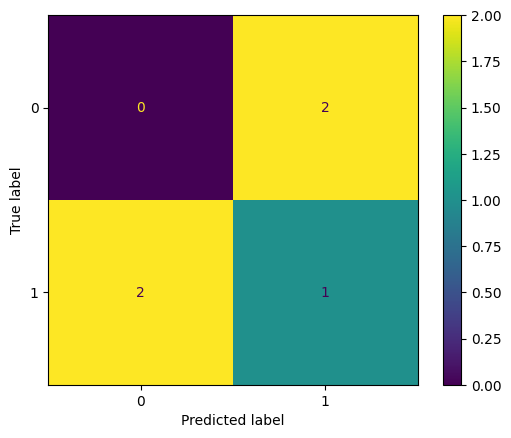

In [40]:
lr2 = LogisticRegression()
lr2.fit(x_train2, y_train2)
predictions2 = lr2.predict(x_test2)

# print classification report
print(classification_report(y_test2, predictions2))
confusionmatrix(predictions2, y_test2)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



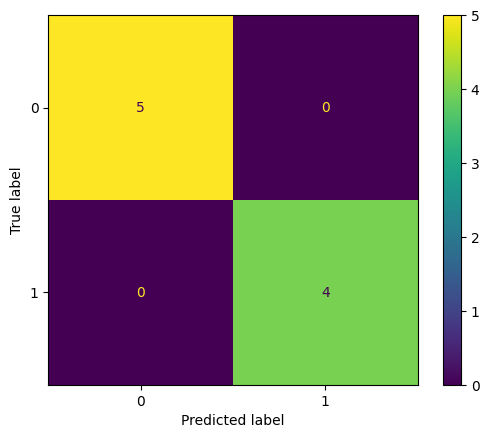

In [41]:
predictions = lr2.predict(x_train2)

# print classification report
print(classification_report(y_train2, predictions))
confusionmatrix(predictions, y_train2)

### Random Forest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        35

    accuracy                           1.00        73
   macro avg       1.00      1.00      1.00        73
weighted avg       1.00      1.00      1.00        73



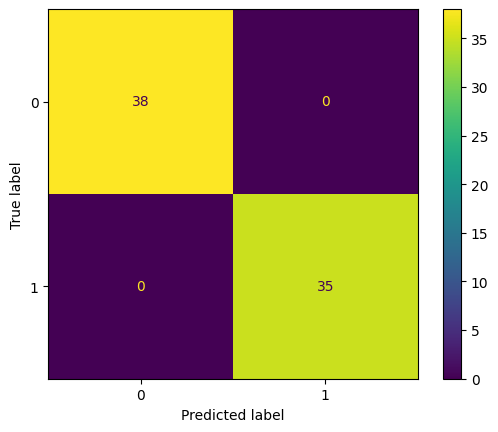

In [42]:
rf_model = RandomForestClassifier().fit(x_train, y_train)
predictions = rf_model.predict(x_test)

# print classification report
print(classification_report(y_test, predictions))
confusionmatrix(predictions, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        83
           1       1.00      1.00      1.00        86

    accuracy                           1.00       169
   macro avg       1.00      1.00      1.00       169
weighted avg       1.00      1.00      1.00       169



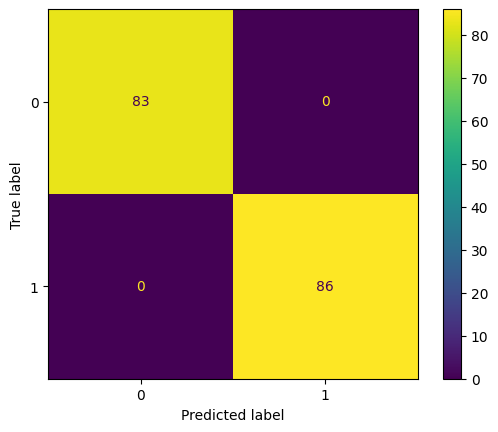

In [43]:
predictions = rf_model.predict(x_train)

# print classification report
print(classification_report(y_train, predictions))
confusionmatrix(predictions, y_train)

### Decision Tree

In [44]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

              precision    recall  f1-score   support

           0       0.91      0.73      0.81        83
           1       0.78      0.93      0.85        86

    accuracy                           0.83       169
   macro avg       0.85      0.83      0.83       169
weighted avg       0.85      0.83      0.83       169



/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


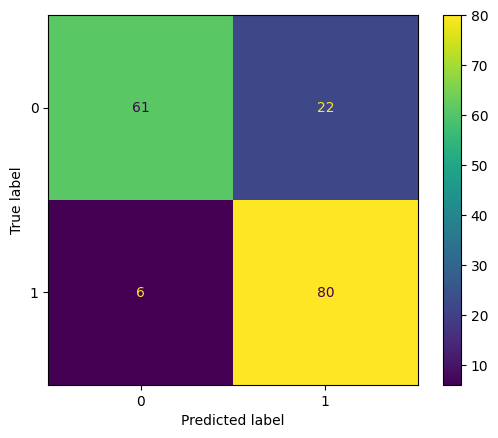

In [46]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features='auto',min_samples_split=10, random_state=42)
model_dt.fit(x_train, y_train)
predictions = model_dt.predict(x_train)
# print classification report
print(classification_report(y_train, predictions))
confusionmatrix(predictions, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

              precision    recall  f1-score   support

           0       0.91      0.73      0.81        83
           1       0.78      0.93      0.85        86

    accuracy                           0.83       169
   macro avg       0.85      0.83      0.83       169
weighted avg       0.85      0.83      0.83       169

{'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 99, 'criterion': 'gini'}
DecisionTreeClassifier(max_depth=99, max_features='auto', min_samples_leaf=2,
                       min_samples_split=5, random_state=42)


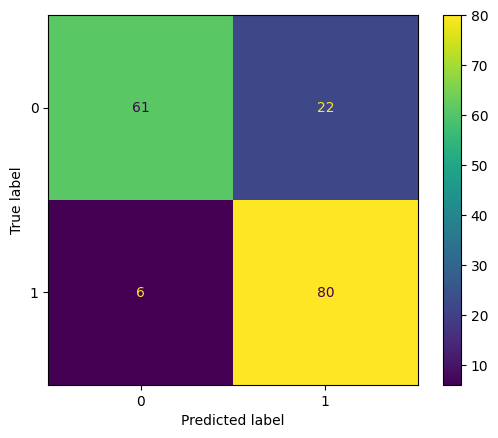

In [47]:
max_depth = [int(x) for x in np.linspace(1,110, num=111)]
min_samples_split = [2,5,10,100]
min_samples_leaf = [1,2,4,10,20,50]
max_features = ['auto','sqrt']
criterion = ['gini','entropy']
splitter = ['best','random']
hyperparameters = dict(max_depth = max_depth, min_samples_split = min_samples_split,
                      min_samples_leaf = min_samples_leaf, max_features=max_features,
                      criterion=criterion, splitter=splitter)

model_dt2 = DecisionTreeClassifier(random_state=42)
rs_dt = RandomizedSearchCV(model_dt2, hyperparameters, scoring='roc_auc')
rs_dt.fit(x_train, y_train)
predictions = model_dt.predict(x_train)
# print classification report
print(classification_report(y_train, predictions))
confusionmatrix(predictions, y_train)

print(rs_dt.best_params_)
print(rs_dt.best_estimator_)

### Feature Importance

In [48]:
B0 = lr1.intercept_
B1 = lr1.coef_[0]
print('Nilai Intercep:', B0.round(2))
print('Coef Regression:', B1.round(2))
Reg = pd.DataFrame({'Feature':x_train.columns, 'Coef_Regression':B1}, index=None)
Reg = Reg.sort_values('Coef_Regression', ascending=False)
Reg

Nilai Intercep: [-0.68]
Coef Regression: [ 0.19 -0.18 -0.19  0.42 -0.15 -0.85  0.25 -0.13  0.43  0.    0.    0.
  0.    0.    0.   -0.03  0.    0.   -0.33  0.    0.    0.    0.    0.
  0.   -0.08  0.   -0.08  0.   -0.25  0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.   -0.74 -0.86  0.51  0.18 -0.39 -0.08
 -0.18 -0.08  0.   -0.34 -0.1  -0.12  0.01 -0.09 -0.75 -0.18  0.    0.
 -0.14  0.44  0.24  0.1   0.14 -0.01  0.11 -0.22  0.3   0.   -1.11  0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.08  0.    0.07
  0.36  0.    0.72  0.    0.    0.   -0.15 -0.15 -0.43  0.   -0.01 -0.53
 -0.6  -0.17  0.    0.    0.   -0.12 -0.06  0.   -0.13  0.    0.17 -0.15
  0.    0.   -0.26 -0.13 -0.05 -0.07  0.03 -0.14  0.13 -0.51 -0.07 -0.12
 -0.    0.03  0.   -0.45  0.   -0.05 -0.01 -0.01 -0.03 -0.26  0.    0.14
  0.    0.33 -0.22 -0.03  0.04 -0.22 -0.29 -0.23 -0.38 -0.03 -0.3  -0.42
  0.02 -0.11 -0.19 -0.

,Feature,Coef_Regression
98,AMT_CREDIT_SUM,0.72
56,SK_ID_PREV_x,0.51
73,NUM_INSTALMENT_VERSION,0.44
8,DAYS_ID_PUBLISH,0.43
3,AMT_ANNUITY_x,0.42
...,...,...
68,CNT_INSTALMENT,-0.75
293,STATUS_X,-0.84
5,REGION_POPULATION_RELATIVE,-0.85
55,AMT_REQ_CREDIT_BUREAU_YEAR,-0.86


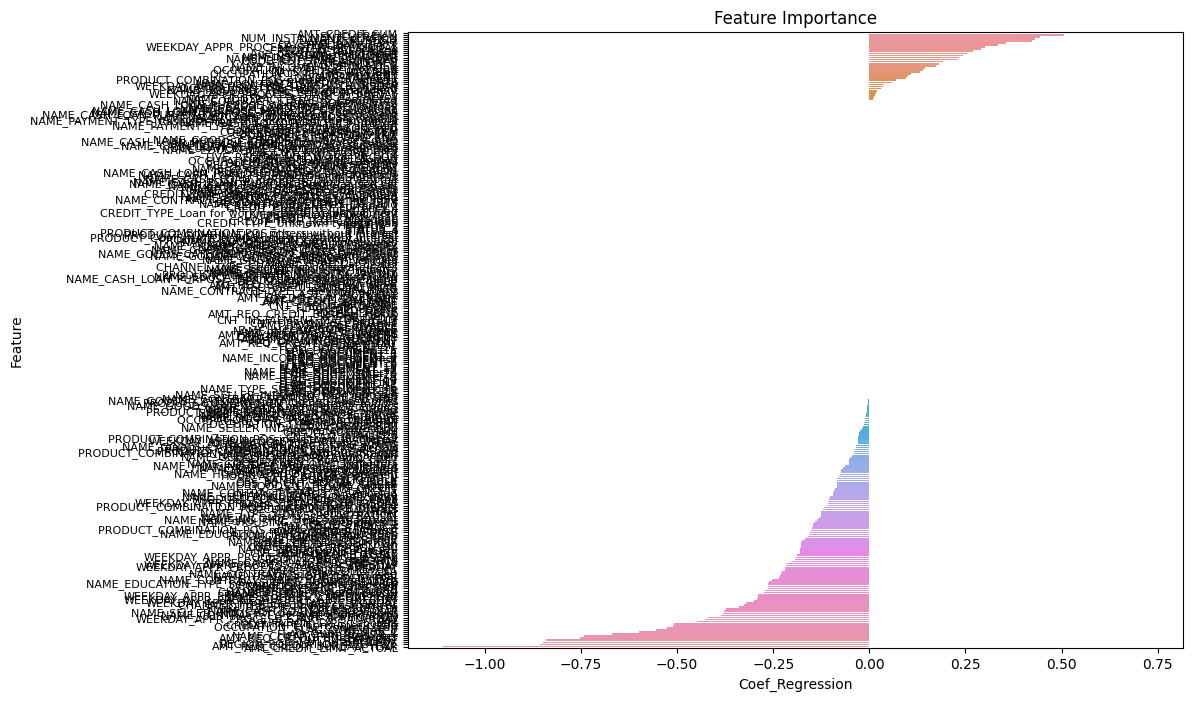

In [49]:
plt.figure(figsize=(10,8))
sns.barplot(x=Reg['Coef_Regression'],y=Reg['Feature'])
plt.title('Feature Importance')
plt.ylabel('Feature', size=10)
plt.yticks(size=8)
plt.show()